# CNN - Project

## Project Description

Have you look at a bird and said "Boahh if only I know what bird that is". 
Unless you're an avid bird spotter (or just love birds in general), it's hard to differentiate some species of birds.
Well you're in luck, turns out you can use a image classifier to identify bird species!

This model is a fine-tuned version of [google/efficientnet-b2](https://huggingface.co/google/efficientnet-b2)
on the [gpiosenka/100-bird-species](https://www.kaggle.com/datasets/gpiosenka/100-bird-species) dataset available on Kaggle.
The dataset used to train the model was taken on September 24th, 2023. 

The original model itself was trained on ImageNet-1K, thus it might still have some useful features for identifying creatures like birds.

In theory, the accuracy for a random guess on this dataset is 0.0019047619 (essentially 1/525). 

## Pre-Requisites

### Installing and Importing Dependencies

In [ ]:
# Installing some dependencies
!pip install -q lightning torchmetrics transformers huggingface accelerate

In [3]:
# Importing data processing and visualisation libraries
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image
from datetime import datetime
import joblib

# Importing the PyTorch libraries
import torch
import torch.nn.functional as F
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split

# Importing the PyTorch Lightning libraries
import lightning as L
from lightning.pytorch.loggers import CSVLogger, TensorBoardLogger
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.utilities.model_summary import ModelSummary
import torchmetrics

# Importing modules from HuggingFace's libraries
from transformers import EfficientNetForImageClassification, EfficientNetImageProcessor, pipeline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 64.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 660.0/660.0 kB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Downloading the Dataset

The model will be trained on the [gpiosenka/100-bird-species](https://www.kaggle.com/datasets/gpiosenka/100-bird-species) dataset available on Kaggle. In order to use the dataset, you will need to download it from Kaggle and upload it to your Google Drive, which requires you to have a Kaggle API key.

In [9]:
# Run only if data is not on disk ()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Creating a folder called 100-bird-species
!mkdir ./100-bird-species

# Downloading the dataset
!kaggle datasets download -d gpiosenka/100-bird-species

# Unzipping the dataset
!unzip -q 100-bird-species.zip -d 100-bird-species

# Removing the zip file
!rm 100-bird-species.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
mkdir: cannot create directory ‘./100-bird-species’: File exists
100% 1.95G/1.96G [01:32<00:00, 23.7MB/s]
100% 1.96G/1.96G [01:32<00:00, 22.6MB/s]


## Loading the Dataset

### Custom Data Module
Since I'm using Lightning to train the model, I'll need to create a custom data module to load the dataset. This data module will also be used to create the dataloaders for training, validation, and testing.

In [10]:
class Birds525DM(L.LightningDataModule):
    def __init__(self, train_dir, val_dir, test_dir,
                 batch_size=32, num_workers=2,
                 train_transforms=None, val_transforms=None, test_transforms=None):

        # Initializing the parent class
        super().__init__()

        # Setting the train, validation and test directories
        self.train_dir = train_dir
        self.val_dir = val_dir
        self.test_dir = test_dir

        # Setting the batch size and number of workers
        self.batch_size = batch_size
        self.num_workers = num_workers

        # Setting the train, validation and test transforms
        self.train_transforms = train_transforms
        self.val_transforms = val_transforms
        self.test_transforms = test_transforms

    def prepare_data(self):
        # Checking if the train, validation and test directories exist
        if os.path.exists(self.train_dir) and os.path.exists(self.val_dir) and os.path.exists(self.test_dir):
            print("The train, validation and test directories exist.")

        # Unhappy path
        else:
            print("The train, validation and test directories do not exist.")

        # Returning nothing because yes
        return

    def setup(self, stage=None):
        # Setting the trainin set
        self.train_dataset = datasets.ImageFolder(self.train_dir, transform=self.train_transforms)

        # Saving the class indices and class names
        self.class_indices = self.train_dataset.class_to_idx
        self.class_names = self.train_dataset.classes

        # Setting the validation set
        self.val_dataset = datasets.ImageFolder(self.val_dir, transform=self.val_transforms)

        # Setting the test set
        self.test_dataset = datasets.ImageFolder(self.test_dir, transform=self.test_transforms)

    def train_dataloader(self):
        # Creating the train dataloader
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True)

    def val_dataloader(self):
        # Creating the validation dataloader
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        # Creating the test dataloader
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=self.num_workers)

    def get_class_indices(self, save_path=None):
        # Saving the class indices
        if save_path is not None:
            joblib.dump(self.class_indices, save_path)

        # Returning the class indices
        return self.class_indices

In [11]:
# Setting the train, validation and test directories
train_dir = "./100-bird-species/train"
val_dir = "./100-bird-species/valid"
test_dir = "./100-bird-species/test"

# Setting the batch size and number of workers
batch_size = 64
num_workers = 2

### Augmentations

Standard stuff pretty much. The training dataset will use stochastic augmentations, while the validation and testing datasets will not be augmented. The image will also be resized to 260x260 beforehand and normalized using the ImageNet statistics.

In [12]:
# Setting the training set transforms (stochastic data augmentation)
train_transforms = transforms.Compose([
    transforms.Resize((260, 260)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Setting the validation and test set transforms (no data augmentation)
val_test_transforms = transforms.Compose([
    transforms.Resize((260, 260)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

### Setting up the Data Module
The data module will now be used to create the dataloaders for training, validation, and testing. The augmentations will be applied to the training dataset, while the validation and test datasets will only be resized and normalized.

In [13]:
# Initializing the data module
dm = Birds525DM(train_dir, val_dir, test_dir,
                batch_size=batch_size, num_workers=num_workers,
                train_transforms=train_transforms,
                val_transforms=val_test_transforms,
                test_transforms=val_test_transforms)

# Preparing the data
dm.prepare_data()

# Setting up the data
dm.setup()

# Getting the class indices and saving them
class_indices = dm.get_class_indices()

# Creating the reverse map
indices_class = {v: k for k, v in class_indices.items()}

# Setting the number of classes
classes = len(class_indices)

The train, validation and test directories exist.


## Training the Model

### Loading the Model from HuggingFace
I'll be using the [google/efficientnet-b2](https://huggingface.co/google/efficientnet-b2) model from HuggingFace. The model will be loaded using the `from_pretrained` method, which will download the model from the HuggingFace Hub if it's not already cached. The model itself was trained on ImageNet-1K, so it might still have some useful features for identifying creatures like birds, but I'll need to chop off the head and replace it with a new one.

In [15]:
# Downloading the EfficientNet-B2 model with ImageNet weights
enb2 = EfficientNetForImageClassification.from_pretrained("google/efficientnet-b2",
                                                           num_labels=classes,
                                                           id2label=indices_class,
                                                           label2id=class_indices,
                                                           ignore_mismatched_sizes=True
                                                         )

# Changing the output layer
enb2.classifier = torch.nn.Linear(in_features=1408,
                                  out_features=classes, bias=True)

Some weights of EfficientNetForImageClassification were not initialized from the model checkpoint at google/efficientnet-b2 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1408]) in the checkpoint and torch.Size([525, 1408]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([525]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Lightning Training Module
As per before, I'll be using Lightning to train the model. The training module will be used to define the model, the optimizer, the loss function, and the training and validation steps. It will also log the training and validation losses and accuracies to TensorBoard.

In [16]:
class ENB2Module(L.LightningModule):
    def __init__(self, model=enb2, learning_rate=1e-5,
                 num_classes=525, top_k=5, patience=2):
        # Initializing the parent class
        super().__init__()

        # Setting the model
        self.model = model

        # Setting the learning rate
        self.learning_rate = learning_rate

        # Setting the number of classes and top k
        self.num_classes = num_classes
        self.top_k = top_k

        # Setting the patience
        self.patience = patience

        # Saving the model hyperparameters
        self.save_hyperparameters(ignore=['model'])

        # Using TorchMetrics to keep track of the accuracy
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes, top_k=top_k)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes, top_k=top_k)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes, top_k=top_k)

    def forward(self, x):
        # Forward pass
        return self.model(x)

    def _shared_step(self, batch):
        # Getting the inputs and labels
        x, y = batch

        # Getting the predictions
        y_hat = self(x)['logits']

        # Calculating the loss
        loss = F.cross_entropy(y_hat, y)

        # Returning the loss and predictions
        return loss, y_hat

    def forward(self, x):
        # Forward pass
        return self.model(x)

    def training_step(self, batch, batch_idx):
        # Getting the loss and predictions
        loss, y_hat = self._shared_step(batch)

        # Updating the training metrics
        self.train_acc(y_hat, batch[1])

        # Logging the training loss
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_acc", self.train_acc, prog_bar=True, on_epoch=True, sync_dist=True)

        # Returning the loss
        return loss

    def validation_step(self, batch, batch_idx):
        # Getting the loss and predictions
        loss, y_hat = self._shared_step(batch)

        # Updating the validation metrics
        self.val_acc(y_hat, batch[1])

        # Logging the validation loss
        self.log("val_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_acc", self.val_acc, on_epoch=True, prog_bar=True, sync_dist=True)

        # Returning the loss
        return loss

    def test_step(self, batch, batch_idx):
        # Getting the loss and predictions
        loss, y_hat = self._shared_step(batch)

        # Updating the test metrics
        self.test_acc(y_hat, batch[1])

        # Logging the test loss
        self.log("test_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        self.log("test_acc", self.test_acc, on_epoch=True, prog_bar=True, sync_dist=True)

        # Returning the loss
        return loss

    def configure_optimizers(self):
        # Creating the optimizer
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)

        # Creating the scheduler
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min",
                                                               patience=self.patience, verbose=True)

        # Returning the optimizer and scheduler
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

### Training the Model
This should be the fun part. I'll be using the `Trainer` class from Lightning to train the model. The model will be trained for 100 epochs. Note, I did not extensively search for the best hyperparameters, so there's a good chance that the model can be trained to a higher accuracy. The model will be trained on a single P100 GPU. Hyperparameters used are as follows:
- Learning Rate: 0.001
- Batch Size: 32
- Optimizer: Adam with Betas (0.9, 0.999)
- Loss Function: Cross Entropy Loss

In [17]:
# Hyperparameters
learning_rate = 1e-3
num_classes = 525
top_k = 1
epoch = 100

In [18]:
# Defining the logger
version_name = f'version-{datetime.now().strftime("%m-%d_%H-%M-%S")}_lr-{str(learning_rate)}_bs-{str(batch_size)}_epoch-{str(epoch)}'
csv_logger = CSVLogger(save_dir="logs/", name="enb2_525_birds",
                       version=version_name)
tb_logger = TensorBoardLogger(save_dir="logs/", name="enb2_525_birds",
                              version=version_name)

# Defining the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor="val_acc",
    dirpath="checkpoints",
    filename="enb2_525_birds-{epoch:02d}-{val_acc:.2f}",
    save_top_k=3,
    mode="max",
)

# Defining the early stopping callback
early_stopping_callback = EarlyStopping(
    monitor="val_acc",
    patience=5,
    mode="max",
    verbose=True
)

In [43]:
# Wrapping the model in a Lightning module
model = ENB2Module(enb2, learning_rate,
                   num_classes=num_classes, top_k=top_k)

# Loading in the weight of the best model checkpoint (if you have the checkpoint)
model = model.load_from_checkpoint(checkpoint_path="./checkpoints/enb2_525_birds-epoch=25-val_acc=0.99.ckpt")

# Printing the model summary
# ModelSummary(model, max_depth=-1)

In [25]:
# Determining the random seed
L.pytorch.seed_everything(42)

# Creating the lightning trainer
trainer = L.Trainer(
                    callbacks=[checkpoint_callback, early_stopping_callback],
                    max_epochs=epoch,
                    accelerator= 'gpu' if torch.cuda.is_available() else 'cpu',
                    devices=-1 if torch.cuda.is_available() else 1,
                    deterministic=True,
                    # logger=[csv_logger, tb_logger],
                    logger=None
                    )

INFO: Global seed set to 42
INFO:lightning.fabric.utilities.seed:Global seed set to 42
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# # Training the model
# trainer.fit(model, dm)

In [ ]:
# Saving the model weights
# torch.save(model.model.state_dict(), "models/enb2_525_birds.pt")

In [26]:
# Using the model on the val set
val_metrics = trainer.validate(model=model, datamodule=dm)

# Printing the validation metrics
val_metrics

The train, validation and test directories exist.


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9859047532081604     │
│         val_loss          │    0.08497069776058197    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.08497069776058197, 'val_acc': 0.9859047532081604}]

In [27]:
# Using the model on the test set
test_metrics = trainer.test(model=model, datamodule=dm)

# Printing the test metrics
test_metrics

The train, validation and test directories exist.


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9912381172180176     │
│         test_loss         │    0.03349841758608818    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.03349841758608818, 'test_acc': 0.9912381172180176}]

In [28]:
# Assigning the accuracy value
accuracy = round(test_metrics[0]['test_acc'], 4) 

# Printing the accuracy
accuracy

0.9912

## Inference

### A Manual Inference Pipeline
This is a manual inference pipeline that will be used to test the model. The pipeline will take in an image, resize it to 260x260, normalize it using the ImageNet statistics, and pass it through the model. The top-K predictions will then be returned.

You'll need the `enb2_525_birds.pt` file in the models folder and `class_indices.pkl` in the data folder to run this pipeline.

In [39]:
# Defining the transformation layer
img_transforms = transforms.Compose([
    transforms.Resize((260, 260)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Creating an inference function
def model_inference(model, image, indices_class,
                    transform, top_k=5):

    # Setting the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Sending the model to device
    model = model.to(device)

    # Setting the model to evaluation mode
    model.eval()

    # Transforming the image
    image = transform(image).unsqueeze(0)

    # Moving the image to the device
    image = image.to(device)

    # Getting the predictions
    with torch.no_grad():
        predictions = model(image)['logits']
        predictions = F.softmax(predictions, dim=-1)

    # Getting the top k predictions
    top_k_predictions = torch.topk(predictions, k=top_k, dim=1)

    # Getting the top k probabilities and indices
    top_k_probabilities = top_k_predictions.values.squeeze().tolist()
    top_k_indices = top_k_predictions.indices.squeeze().tolist()

    # Getting the top k classes
    top_k_classes = [indices_class[i] for i in top_k_indices] \
                    if type(top_k_indices) != int else indices_class[top_k_indices]

    # Returning the top k probabilities and classes
    return top_k_probabilities, top_k_classes

In [40]:
# Defining a function to plot the image as well as the prediction
def plot_predict(image, model, indices_class, transform, top_k=1, save_path=None):
    # Getting the top k probabilities and classes
    top_k_probabilities, top_k_classes = model_inference(model, image, indices_class, transform=transform, top_k=top_k)

    # Plotting the image
    plt.imshow(image)

    # Setting the title
    plt.title(f"Prediction: {top_k_classes} ({round(top_k_probabilities, 4) * 100}%)")

    # Removing the axis
    plt.axis("off")

    # Saving the plot if needed
    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)

    # Showing the plot
    plt.show()

In [35]:
# Loading the class-to-indices map
class_indices = joblib.load('class_indices.pkl')

# Reversing the class-to-indices map
indices_class = {v: k for k, v in class_indices.items()}

In [ ]:
# Loading the model
enb2 = EfficientNetForImageClassification.from_pretrained("google/efficientnet-b2",
                                                           num_labels=classes,
                                                           id2label=indices_class,
                                                           label2id=class_indices,
                                                           ignore_mismatched_sizes=True
                                                         )

# Changing the output layer
enb2.classifier = torch.nn.Linear(in_features=1408,
                                  out_features=classes, bias=True)

# Loading the model weights
enb2.load_state_dict(torch.load("models/enb2_525_birds.pt"))

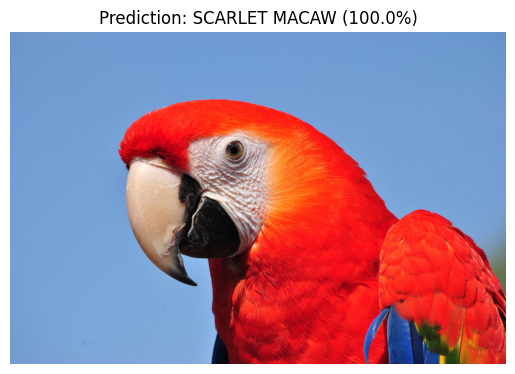

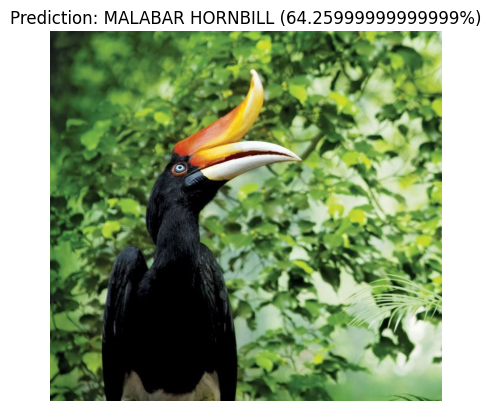

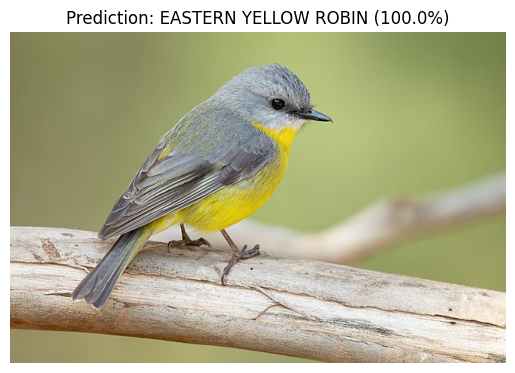

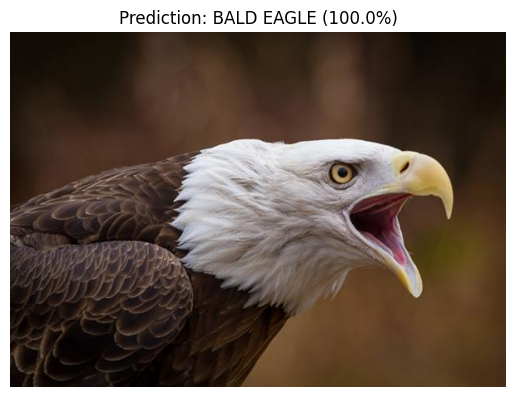

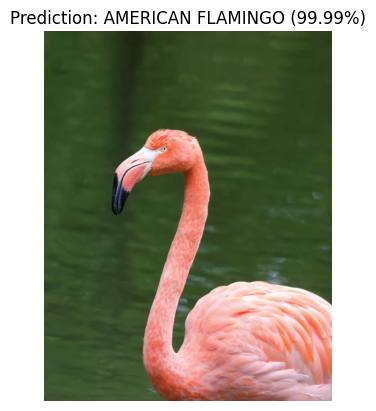

In [37]:
# Loading the image
test_dir = "./test_images/"
images = [Image.open(os.path.join(test_dir, path)) for path in os.listdir(test_dir)]

# Using the model for inference
for image in images:
    plot_predict(model=model,
                 image=image,
                 transform=img_transforms,
                 indices_class=indices_class)

### Alternative Inference Pipeline
Well that was a lot of work, thankfully I've published the model to the [HuggingFace Hub](https://huggingface.co/dennisjooo/Birds-Classifier-EfficientNetB2), so you can just use the `pipeline` method to run inference on the model. Easy peasy.

In [ ]:
# Loading the model and preprocessor using Pipeline
pipe = pipeline("image-classification", model="dennisjooo/Birds-Classifier-EfficientNetB2")

# Running the inference
result = pipe(images)

# Printing the result label
print(result['label'])